# Analysis of AB Value Net

In [1]:
import os
os.chdir('../src')
import numpy as np
import matplotlib.pyplot as plt
import torch
from engine import BigBoard
from dataset import board_to_planes
from network import ABNet
from alphabeta import ABTree, RandABTree

In [2]:
def load_model(name):
    m = ABNet()
    m.load_state_dict(torch.load(f'../models/{name}.pt', map_location='cpu'))
    return m.eval()

def value_head(m, board):
    v = np.full((9,9), np.nan)
    for i,j in np.ndindex(9,9):
        if not board.legal_moves[i][j]:
            continue
        b = board.copy()
        b.move(i, j)
        with torch.no_grad():
            value = m(board_to_planes(b))
        v[i, j] = value
    v = torch.tensor(v).view(3, 3, 3, 3)
    v = torch.cat(v.chunk(3, dim=0), dim=2)
    v = torch.cat(v.chunk(3, dim=1), dim=3)
    return v.squeeze().numpy()


cm = plt.cm.RdBu
cm.set_bad('gray')    
def plot_heads(v):
    vmax = 100*np.nanmax(np.abs(v))
    plt.imshow(100*v, vmin=-vmax, vmax=vmax, cmap=cm)
    plt.colorbar()
    # plt.title('Value Head (centi)')

In [3]:
a = BigBoard()
b = BigBoard(boards=[
    (1,0,0,0,0,0,0,2,2),
    (0,2,2,0,0,1,1,0,0),
    (0,0,2,1,0,1,1,0,0),
    (0,0,0,2,0,0,1,1,1),
    (0,0,2,0,2,0,2,0,1),
    (0,2,0,2,1,0,0,2,0),
    (0,0,1,0,0,1,2,2,2),
    (0,1,0,2,1,0,0,1,0),
    (1,1,1,0,0,2,0,0,2)
], mover=1, sectors=(2,))
b.draw()

c = b.copy()
c.move(2,4)

game1 = [(4, 4), (4, 0), (0, 5), (5, 5), (5, 7), (7, 7), (7, 5), (5, 8), (8, 3), (3, 3), (3, 7), (7, 8), (8, 0), (0, 0), (0, 8), (8, 6), (6, 5), (5, 2), (2, 3), (3, 6), (6, 8), (8, 8), (8, 1), (1, 1), (1, 3), (3, 0), (0, 2), (2, 2), (2, 6), (6, 2), (2, 0), (4, 6), (6, 1), (1, 8), (8, 2), (4, 3)]
game2 = [(4, 4), (4, 6), (6, 6), (6, 1), (1, 1), (1, 5), (5, 5), (5, 0), (0, 0), (0, 1), (1, 2), (2, 1), (1, 0), (0, 8), (8, 8), (8, 0), (0, 3), (3, 2), (2, 2), (2, 6), (6, 0), (0, 2), (2, 5), (5, 7), (7, 7), (7, 8), (8, 5), (5, 6), (6, 3), (3, 8), (8, 2), (2, 7), (7, 2), (2, 4), (4, 5), (5, 3), (3, 3), (3, 7), (7, 4), (4, 0), (0, 4), (4, 1), (7, 1)]
win1 = BigBoard()
for m in game1[:-1]: win1.move(*m)
win2 = BigBoard()
for m in game2[:-1]: win2.move(*m)
    
def plot_abc(model):
    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    plot_heads(value_head(m, a))
    plt.title('Starting position')
    plt.subplot(132)
    plot_heads(value_head(m, b))
    plt.title('O can win')
    plt.subplot(133)
    plot_heads(value_head(m, c))
    plt.title('X to draw')
    plt.show()
    

     X │   │   ┃   │ O │ O ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │   │ X ┃ X │   │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │ O │ O ┃ X │   │   ┃ X │   │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │   ┃   │   │ O ┃   │ O │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │   │   ┃   │ O │   ┃ O │ X │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     X │ X │ X ┃ O │   │ X ┃   │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │ X ┃   │ X │   ┃ X │ X │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │ X ┃ O │ X │   ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │ O │ O ┃   │ X │   ┃   │   │ O         
Mover: O, sector: (2,)
       │   │   
    ───┼───┼───
     X │ O │   
    ───┼───┼───
     O │ X │ X     


* 2,1 is win for O in 2
* 2,0 is win for O in 3
* Other moves, X plays 2,0 to win the sector and guarantee at least a draw

## 10k from random
* Starting position favors center corners (see selfplay win rate analysis).
* Seems like value network already evaluates endgame positions fairly well.
* Overfit network seems to have a worse value head.

In [4]:
m = load_model('1000_10000bs2048lr0.1d0.001abe5')

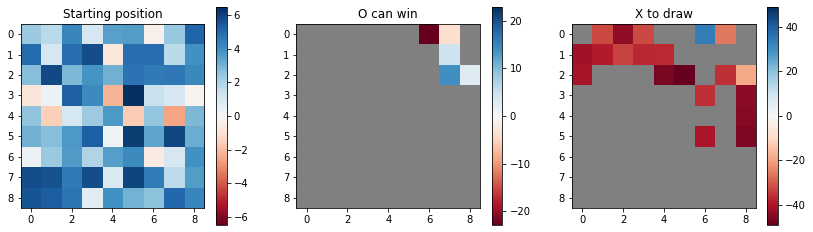

In [5]:
plot_abc(m)

In [7]:
m = load_model('1000_10000bs2048lr0.1d0.001abe10')

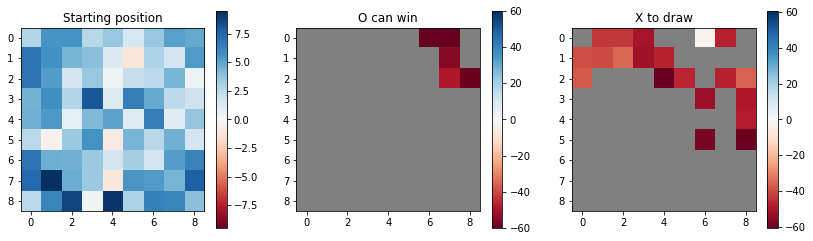

In [8]:
plot_abc(m)